In [0]:
!kaggle competitions download -c plant-seedlings-classification

In [0]:
ls

In [0]:
ls .kaggle/competitions/plant-seedlings-classification/

In [0]:
!mkdir plant_seedlings

In [0]:
!cp .kaggle/competitions/plant-seedlings-classification/* plant_seedlings/

In [0]:
cd plant_seedlings/

In [0]:
ls

sample_submission.csv      test.zip  training.log
sample_submission.csv.zip  train/    train.zip


In [0]:
!unzip train.zip
!unzip sample_submission.csv.zip

In [0]:
ls

In [0]:
ls train/

In [0]:
import os

labels_list = os.listdir('./train')
num_labels = len(labels_list)

print(labels_list)
print(num_labels)

['Common Chickweed', 'Cleavers', 'Maize', 'Sugar beet', 'Fat Hen', 'Loose Silky-bent', 'Charlock', 'Black-grass', 'Small-flowered Cranesbill', 'Scentless Mayweed', 'Common wheat', 'Shepherds Purse']
12


No of images in Common Chickweed directory are 611
No of images in Cleavers directory are 287
No of images in Maize directory are 221
No of images in Sugar beet directory are 385
No of images in Fat Hen directory are 475
No of images in Loose Silky-bent directory are 654
No of images in Charlock directory are 390
No of images in Black-grass directory are 263
No of images in Small-flowered Cranesbill directory are 496
No of images in Scentless Mayweed directory are 516
No of images in Common wheat directory are 221
No of images in Shepherds Purse directory are 231



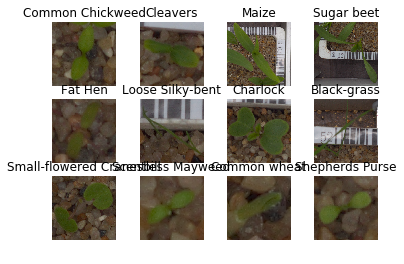

(97, 97, 3)


In [0]:
import matplotlib.pyplot as plt

plt.figure(1)

for idx, label in enumerate(labels_list):
  label_path = os.path.join('./train', label)
  images_list = os.listdir(label_path)
  num_images = len(images_list)
  img_name = images_list[0]
  img_path = os.path.join('./train', label, img_name)
  img = plt.imread(img_path)
  
  plt.subplot(3,4,idx+1)
  plt.imshow(img)
  plt.title(label)
  plt.axis('off')
  
  print('No of images in {} directory are {}'.format(label, num_images))

print()
plt.show()
print(img.shape)

In [0]:
import glob

X = []
y = []

for label in labels_list:
  images_list = glob.glob(os.path.join('./train',label,'*.png'))
  num_images = len(images_list)
  X += images_list
  y += [label]*num_images
  
print('X:', len(X))
print('y:', len(y))  

X: 4750
y: 4750


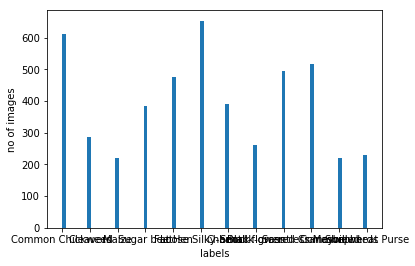

In [0]:
# Histogram

plt.hist(y, bins=86)
plt.xlabel('labels')
plt.ylabel('no of images')
plt.show()

In [0]:
# Split Data

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

X, X_test, y, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=0, stratify=y)

del X[:]
del y[:]

print('Train:', len(X_train), len(y_train))
print('Valid:', len(X_valid), len(y_valid))
print('Test:', len(X_test), len(y_test))

Train: 3420 3420
Valid: 380 380
Test: 950 950


In [0]:
ls

sample_submission.csv      test.zip  training.log
sample_submission.csv.zip  train/    train.zip


In [0]:
if not os.path.exists('./data'):
  os.mkdir('./data')

data_types = ['train', 'validation', 'test']

for data_type in data_types:
  data_type_path = os.path.join('./data', data_type)
  if not os.path.exists(data_type_path):
    os.mkdir(data_type_path)
    for label in labels_list:
      path = os.path.join('./data', data_type, label)
      os.mkdir(path)

In [0]:
from PIL import Image

def write_data(X, y, name, idx):
  print(name)
  for i in range(len(X)):
    img = Image.open(X[i])
    img = img.resize((299, 299))
    img_path = os.path.join('./data', name, y[i], str(idx) + '.png')
    img.save(img_path)
    idx += 1
    if idx % 300 == 0:
      print('{} images completed.'.format(idx))
    
  return idx
    

In [0]:
%%time

idx = 0

idx = write_data(X_train, y_train, 'train', idx)
idx = write_data(X_valid, y_valid, 'validation', idx)
idx = write_data(X_test, y_test, 'test', idx)



train
300 images completed.
600 images completed.
900 images completed.
1200 images completed.
1500 images completed.
1800 images completed.
2100 images completed.
2400 images completed.
2700 images completed.
3000 images completed.
3300 images completed.
validation
3600 images completed.
test
3900 images completed.
4200 images completed.
4500 images completed.
CPU times: user 2min 39s, sys: 1.73 s, total: 2min 41s
Wall time: 2min 40s


In [0]:
# Verify

print('Train:', len(glob.glob('./data/train/*/*.png')))
print('Valid:', len(glob.glob('./data/validation/*/*.png')))
print('Test:', len(glob.glob('./data/test/*/*.png')))

Train: 3420
Valid: 380
Test: 950


In [0]:
width, height, depth = 299, 299, 3

In [0]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K
from keras.applications.inception_v3 import InceptionV3
from keras.layers import Input

from keras import __version__
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.models import Model, load_model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD

from keras.callbacks import TensorBoard
from keras.callbacks import TerminateOnNaN
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.callbacks import CSVLogger

In [0]:
train_data_dir = 'data/train'
validation_data_dir = 'data/validation'
test_data_dir = 'data/test'

nb_train_samples = len(X_train)
nb_validation_samples = len(X_valid)
nb_test_samples = len(X_test)

input_shape = (width, height, depth)

In [0]:
epochs = 20
batch_size = 16
fc_size = 1024

In [0]:
# Data Generators

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

In [0]:
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(height, width),
    batch_size=batch_size)

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(height, width),
    batch_size=batch_size)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(height, width),
    batch_size=batch_size)

Found 3420 images belonging to 12 classes.
Found 380 images belonging to 12 classes.
Found 950 images belonging to 12 classes.


In [0]:
# Warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=FutureWarning)
    import numpy as np
    import tensorflow as tf
    import h5py as h5py
    import keras

In [0]:
%%time

# setup model

input_tensor = Input(shape=input_shape)

base_model = InceptionV3(input_tensor=input_tensor, weights='imagenet', include_top=False) #include_top=False excludes final FC layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(fc_size, activation='relu')(x) #new FC layer, random init
predictions = Dense(num_labels, activation='softmax')(x) #new softmax layer
model = Model(input=base_model.input, output=predictions)

# Callbacks

# TerminateOnNaN
terminate_callback = TerminateOnNaN()

# Tensorboard
tb_callback = TensorBoard('./Graph', histogram_freq=0, write_graph=True, write_images=True)

# Model Checkppoint
ckpt_callback = ModelCheckpoint('./weights.{epoch:02d}-{val_loss:.2f}.hdf5', verbose=1, save_weights_only=False, mode='auto', period=4)

# Early Stopping
stopping_callback = EarlyStopping(monitor='val_loss', patience=2, verbose=1, mode='auto')

# CSV Logger
csv_logger = CSVLogger('./training.log')

# Callbacks list
callbacks = [terminate_callback, tb_callback, ckpt_callback, csv_logger]

# Transfer learn
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

T_L = model.fit_generator(
        train_generator,
        nb_epoch=epochs,
        samples_per_epoch=len(X_train),
        validation_data=validation_generator,
        nb_val_samples=len(X_valid),
        class_weight='auto',
        callbacks = callbacks)

model.save('plant_seedlings_tl.h5')

model = load_model('plant_seedlings_tl.h5')

# Fine Tuning

NB_IV3_LAYERS_TO_FREEZE = 172

for layer in model.layers[:NB_IV3_LAYERS_TO_FREEZE]:
    layer.trainable = False
for layer in model.layers[NB_IV3_LAYERS_TO_FREEZE:]:
    layer.trainable = True

model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
F_T = model.fit_generator(
        train_generator,
        samples_per_epoch=len(X_train),
        nb_epoch=epochs,
        validation_data=validation_generator,
        nb_val_samples=len(X_valid),
        class_weight='auto',
        callbacks = callbacks)

model.save('plant_seedlings_ft.h5')


# https://deeplearningsandbox.com/how-to-use-transfer-learning-and-fine-tuning-in-keras-and-tensorflow-to-build-an-image-recognition-94b0b02444f2


# View tensorboard
#tensorboard --logdir ./Graph


/home/gogadi/anaconda3/envs/dl/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  # This is added back by InteractiveShellApp.init_path()
/home/gogadi/anaconda3/envs/dl/lib/python3.6/site-packages/ipykernel_launcher.py:46: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/home/gogadi/anaconda3/envs/dl/lib/python3.6/site-packages/ipykernel_launcher.py:46: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras.pre..., validation_data=<keras.pre..., class_weight="auto", callbacks=[<keras.c

Epoch 1/20
213/213 [==============================] - 164s 772ms/step - loss: 2.3813 - acc: 0.3498 - val_loss: 1.9371 - val_acc: 0.3238
Epoch 2/20
213/213 [==============================] - 165s 773ms/step - loss: 1.2881 - acc: 0.5488 - val_loss: 2.0310 - val_acc: 0.3761
Epoch 3/20
213/213 [==============================] - 165s 773ms/step - loss: 1.0798 - acc: 0.6345 - val_loss: 1.4843 - val_acc: 0.5282
Epoch 4/20
213/213 [==============================] - 164s 770ms/step - loss: 0.9813 - acc: 0.6618 - val_loss: 2.3819 - val_acc: 0.3771

Epoch 00004: saving model to ./weights.04-2.38.hdf5
Epoch 5/20
213/213 [==============================] - 164s 769ms/step - loss: 0.8672 - acc: 0.7001 - val_loss: 2.0032 - val_acc: 0.4648
Epoch 6/20
213/213 [==============================] - 165s 774ms/step - loss: 0.8208 - acc: 0.7209 - val_loss: 3.2405 - val_acc: 0.2897
Epoch 7/20
213/213 [==============================] - 164s 769ms/step - loss: 0.8056 - acc: 0.7166 - val_loss: 2.4294 - val_acc: 0.

/home/gogadi/anaconda3/envs/dl/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/home/gogadi/anaconda3/envs/dl/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras.pre..., validation_data=<keras.pre..., class_weight="auto", callbacks=[<keras.ca..., steps_per_epoch=213, epochs=20, validation_steps=380)`


Epoch 1/20
213/213 [==============================] - 176s 827ms/step - loss: 0.4470 - acc: 0.8442 - val_loss: 1.3342 - val_acc: 0.5817
Epoch 2/20
213/213 [==============================] - 174s 816ms/step - loss: 0.3409 - acc: 0.8835 - val_loss: 1.1967 - val_acc: 0.6296
Epoch 3/20
213/213 [==============================] - 174s 815ms/step - loss: 0.3184 - acc: 0.8900 - val_loss: 1.1794 - val_acc: 0.6470
Epoch 4/20
213/213 [==============================] - 174s 815ms/step - loss: 0.2591 - acc: 0.9082 - val_loss: 1.1059 - val_acc: 0.6713

Epoch 00004: saving model to ./weights.04-1.11.hdf5
Epoch 5/20
213/213 [==============================] - 173s 811ms/step - loss: 0.2356 - acc: 0.9114 - val_loss: 1.0327 - val_acc: 0.6887
Epoch 6/20
213/213 [==============================] - 173s 814ms/step - loss: 0.2206 - acc: 0.9227 - val_loss: 1.0046 - val_acc: 0.6877
Epoch 7/20
213/213 [==============================] - 174s 815ms/step - loss: 0.2081 - acc: 0.9219 - val_loss: 0.9237 - val_acc: 0.

In [0]:
model = load_model('plant_seedlings_ft.h5')

Eval = model.evaluate_generator(test_generator)


In [0]:
Eval

[0.7661930168302435, 0.7578947367166218]

In [0]:
ls

anaconda3/    cuda-setup/        Plant_Seedlings_Intel.ipynb
CudaSamples/  cudnn_samples_v7/


In [0]:
ls

In [0]:
!rm -rf data/
!rm -rf Graph/
!rm -rf ngrok
!rm ngrok-stable-linux-amd64.zip

In [0]:
ls

In [0]:
!rm plant_seedlings_tl.h5
!rm weights.04-3.17.hdf5

In [0]:
ls